In [202]:
import pandas as pd

df = pd.read_excel("data/nph_3069_sm_tables2.xls", sheet_name="Sheet1",
                   header=5, skipfooter=5, usecols="A:B,D:P,R:AC") \
    .fillna(0) \
    .drop(0)   \
    .rename(columns={"Unnamed: 0": "Tree", "Unnamed: 1": "Cohort"})
df = df.astype({k: int for k in df.columns[2:]})
df["Tree"] = df["Tree"].replace("a|b", "", regex=True).astype(int)
df

,Tree,Cohort,VES-01,VES-02,VES-03,VES-04,VES-05,VES-06,VES-07,VES-08,...,VIN-03,VIN-04,VIN-05,VIN-06,VIN-07,VIN-08,VIN-09,VIN-10,VIN-11,VIN-12
1,37,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,39,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,40,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,42,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,64,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75,83,4,0,1,0,0,0,11,3,0,...,2,0,0,0,0,0,0,0,0,0
76,85,4,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
77,86,4,3,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

B = nx.Graph()

# add genets nodes
B.add_nodes_from(df.columns[2:], bipartite=0)

# add tree nodes
for _, row in df.iterrows():
    B.add_node(row["Tree"], bipartite=1, cohort=row["Cohort"])

edges = []
# add edges between genets and trees
for _, row in df.iterrows():
    for genet, n in row[2:].items():
        if n > 0:
            edges.append((genet, row["Tree"]))
            
B.add_edges_from(edges)
B.remove_nodes_from([x for x in B.nodes() if B.degree(x) == 0])
B.remove_nodes_from(("VES-11", 79)) # disconnected part

Trees: 55, genets: 24


/tmp/ipykernel_3180375/97471379.py:23: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


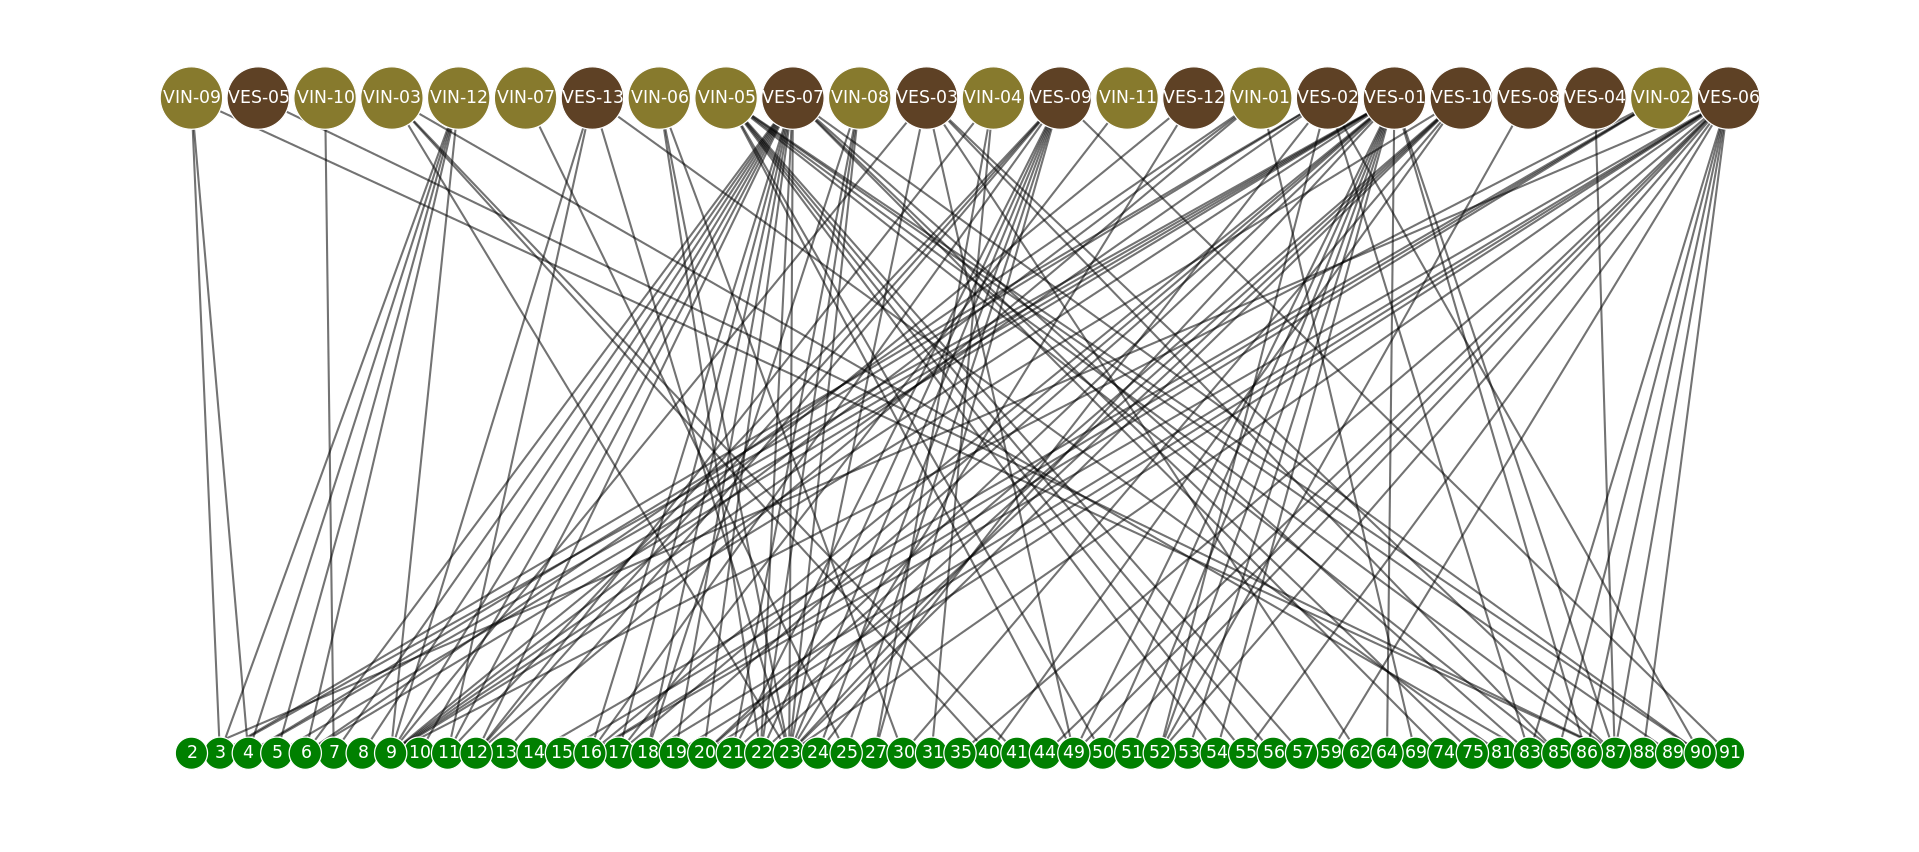

In [204]:
fungi, trees = bipartite.sets(B)
print(f"Trees: {len(trees)}, genets: {len(fungi)}")
pos = nx.bipartite_layout(B, trees, align="horizontal")

node_sizes = []
node_colors = []
for node in B.nodes:
    if B.nodes[node]["bipartite"] == 1:
        node_sizes.append(60)
        node_colors.append("green")
    else:
        node_sizes.append(225)
        if node[0:3] == "VES":
            node_colors.append("#5e4125")
        else:
            node_colors.append("#877a2d")

plt.figure(figsize=(8, 3.5), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(B, pos=pos, node_size=node_sizes, node_color=node_colors, linewidths=0.3, edgecolors="white")
nx.draw_networkx_labels(B, pos, font_color="white", font_size=4.15)
nx.draw_networkx_edges(B, pos, alpha=0.55, width=[0.5 for _ in range(len(B.nodes))])
plt.gca().set_axis_off()
plt.show()

Avg. degree: 19.490909090909092; Max degree: 47 (tree 23)


/tmp/ipykernel_3180375/3836026401.py:32: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


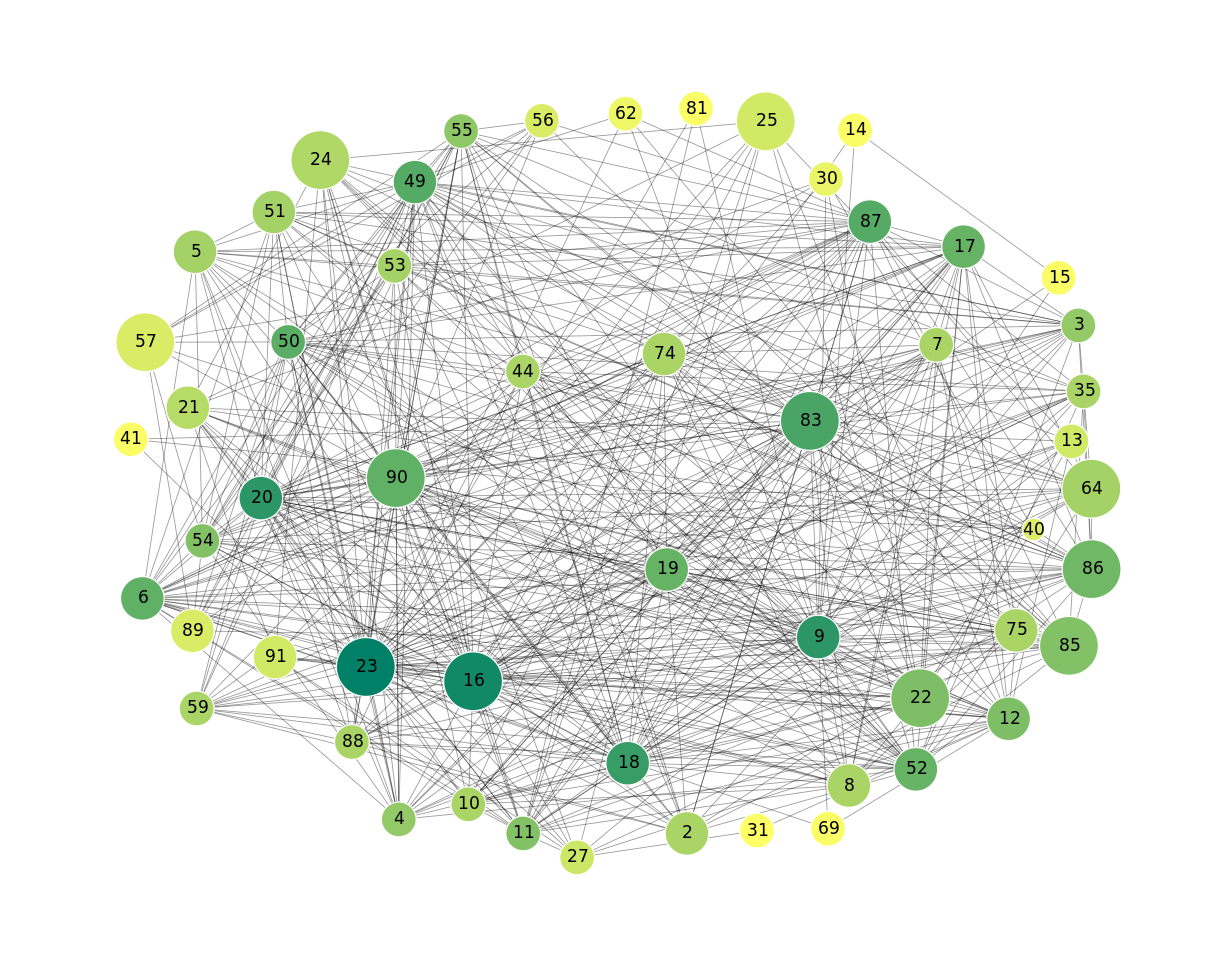

In [225]:
import matplotlib as mpl

G = bipartite.weighted_projected_graph(B, trees)
degrees_dict = {n: d for n, d in G.degree()}
degrees = list(degrees_dict.values())
sorted_degrees = sorted(degrees_dict, key=degrees_dict.get)
print(f"Avg. degree: {np.average(degrees)}; Max degree: {np.max(degrees)} (tree {sorted_degrees[-1]})")
# print(nx.get_edge_attributes(G, "weight"))

pos = nx.spring_layout(G, k=3,seed=99192, weight=None)

# pos[sorted_degrees[-1]] = (-1, -1)
# pos[sorted_degrees[-2]] = (0, -1)
# pos[sorted_degrees[-3]] = (1, -1)
# pos[sorted_degrees[-4]] = (1, 1)
# pos[sorted_degrees[-5]] = (0, 1)
# pos[sorted_degrees[-6]] = (-1, 1)

node_sizes = []
size_values = {1: 30, 2: 70, 3:110, 4: 200}

for node in G.nodes:
    idx = G.nodes[node]["cohort"]
    node_sizes.append(size_values[idx])

plt.figure(figsize=(5, 4), dpi=300, facecolor="w", frameon=False)
nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=degrees,
                       edgecolors="white", linewidths=0.3, cmap=mpl.cm.summer_r)
nx.draw_networkx_labels(G, pos, font_color="black", font_size=4.1)
nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))])
plt.gca().set_axis_off()
plt.show()

/tmp/ipykernel_3180375/2609373657.py:6: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


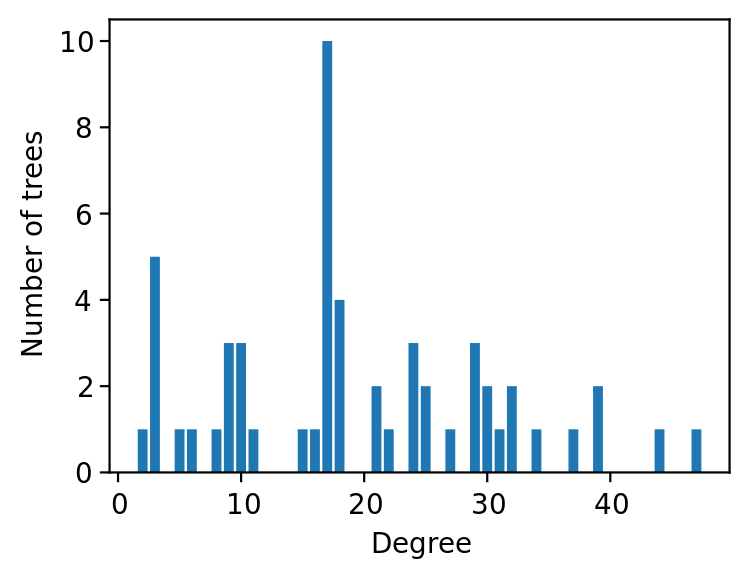

In [206]:
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = fig.add_subplot()
ax.bar(*np.unique(sorted(degrees, reverse=True), return_counts=True))
ax.set_xlabel("Degree")
ax.set_ylabel("Number of trees")
plt.show()